In [19]:
import pandas as pd
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import os
import cv2
import shutil
from torchvision import datasets, transforms


In [ ]:
# Unzipping the Uploaded file
!unzip '/content/drive/MyDrive/dataset.zip'

Some visulizations


In [21]:
# This code tells the statistics about the dataset:

dataset_path = "/content/mammals"

# Get the list of subfolders (categories) in the dataset
categories = os.listdir(dataset_path)

# Display the total number of categories
print("Total Categories:", len(categories))


Total Categories: 45


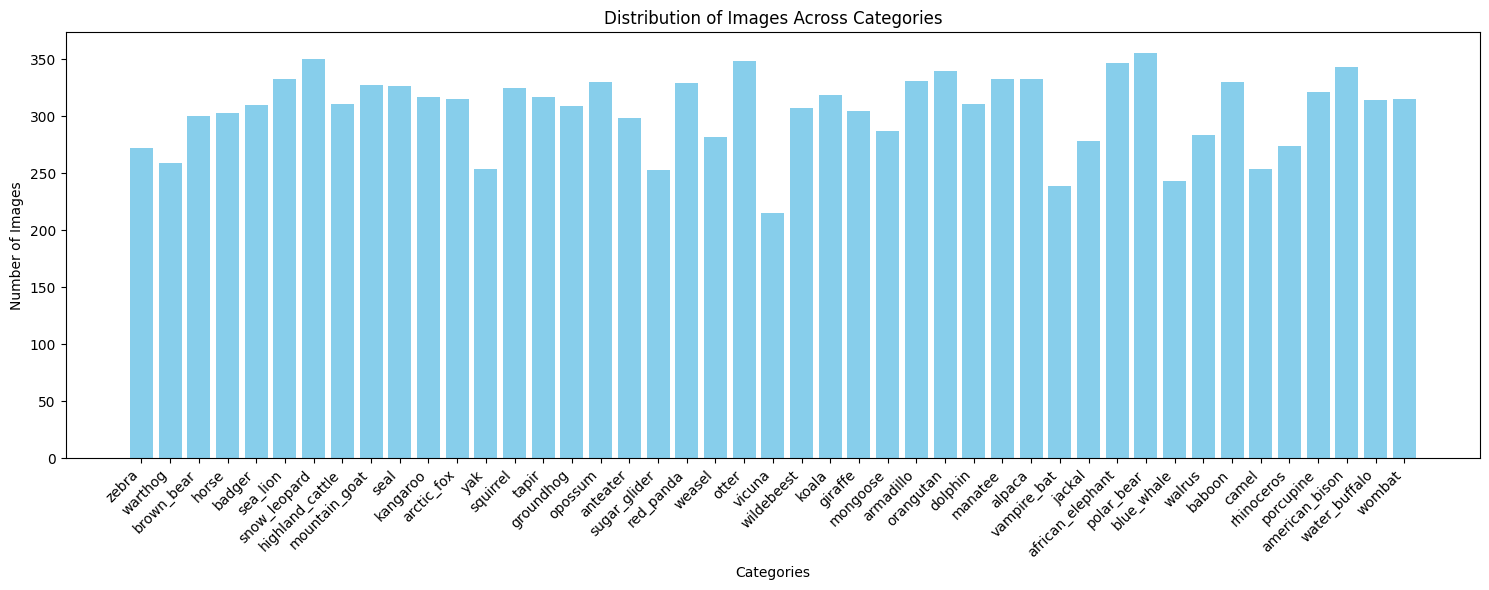

In [22]:
#visual representation
# Lists to store category names and corresponding image counts
category_names = []
image_counts = []

# Iterate through each category and count the number of images
for category in categories:
    category_path = os.path.join(dataset_path, category)

    # Get the list of all files in the category folder
    image_files = os.listdir(category_path)

    # Store category name and image count in lists
    category_names.append(category)
    image_counts.append(len(image_files))

# Plot the bar chart
plt.figure(figsize=(15, 6))
plt.bar(category_names, image_counts, color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [23]:
# Setting up a grid of subplots
num_categories = len(categories)
num_rows = 3
num_cols = 15

# Create a figure for the grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(40, 12))

# Loop through each category and show the first image in the grid
for i, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    image_files = os.listdir(category_path)

    # Display the first image in each category
    if image_files:
        first_image_path = os.path.join(category_path, image_files[0])
        first_image = cv2.imread(first_image_path)

        # Subplotting
        # this is calculating at which index in the grid it should populate the image
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(first_image)
        ax.set_title(f"Category: {category}")
        ax.axis("off")

# Display the grid of images
plt.show()

Output hidden; open in https://colab.research.google.com to view.

There can be two techniques to go ahead, divide your main data into training, testing and validation and then performing preprocessing,
or perform preprocessing and then divide. I am dividing my dataset and then performing preprocessing

In [24]:
# function for splitting the dataset

def split_data(source_folder, target_folder, train_size=0.7, val_size=0.2):

    categories = os.listdir(source_folder)
    for category in categories:
        os.makedirs(os.path.join(target_folder, 'train', category), exist_ok=True)
        os.makedirs(os.path.join(target_folder, 'val', category), exist_ok=True)
        os.makedirs(os.path.join(target_folder, 'test', category), exist_ok=True)

        # Get a list of pictures
        all_images = os.listdir(os.path.join(source_folder, category))
        np.random.shuffle(all_images)  # Shuffle the list

        # Calculate split indices
        train_split_index = int(len(all_images) * train_size)
        val_split_index = train_split_index + int(len(all_images) * val_size)

        # Splitting the dataset
        train_images = all_images[:train_split_index]
        val_images = all_images[train_split_index:val_split_index]
        test_images = all_images[val_split_index:]

        # Copying files to train, val, and test directories
        for image in train_images:
            source_path = os.path.join(source_folder, category, image)
            dest_path = os.path.join(target_folder, 'train', category, image)
            shutil.copyfile(source_path, dest_path)

        for image in val_images:
            source_path = os.path.join(source_folder, category, image)
            dest_path = os.path.join(target_folder, 'val', category, image)
            shutil.copyfile(source_path, dest_path)

        for image in test_images:
            source_path = os.path.join(source_folder, category, image)
            dest_path = os.path.join(target_folder, 'test', category, image)
            shutil.copyfile(source_path, dest_path)


In [25]:
# Calling split_data() for our dataset

source_folder = '/content/mammals'
target_folder = '/content'
split_data(source_folder, target_folder)

In [26]:
# Naming the path to variables

train_data='/content/train'
test_data='/content/test'
val_data='/content/val'

Now in order for pre-processing, we can use functions, but that takes a lot of space, as we are going to use transfer learning, all "All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]."

In [27]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])



test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])

val_transforms=transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])

In [28]:
train_data = datasets.ImageFolder(train_data,
                               transform=train_transforms)

val_data = datasets.ImageFolder(val_data,
                               transform=val_transforms)

test_data = datasets.ImageFolder(test_data,
                               transform=test_transforms)

In [29]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Transfer Learning

In [30]:
# We leverage the power of transfer learning, when choosing transfer learning and models, some of the factors that should be looked upon are
# model perfomance, model compatibility with our framework, model reviews, what data its already trained on and whether its
# somewhat related to our data, for example we cannot choose a model that is trained on sattelite images or text data,
# that will not facilitate our model performance
# further more for selecting the right model, we can see the official documentation of deep learning framerworks and libraries, we can see which models best meet our needs
# we can also refer to research papers and journals
#after selecting the right model we can then finetune it for our dataset

In [31]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [32]:
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [33]:
# Modify the last layer for your specific task
num_classes = 45  # Replace with the actual number of classes in your dataset

# Get the number of input features for the classifier
num_ftrs = model.classifier.in_features

# Replace the last layer with a new fully connected layer
model.classifier = torch.nn.Linear(num_ftrs, num_classes)


In [34]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using {device} device")



Using cuda device


Moving them to device: gpu

In [35]:
# Moving the model to GPU
model = model.to(device)

# Define the loss function (cross-entropy)
criterion = torch.nn.CrossEntropyLoss()

# Define the optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)




In [36]:
# Number of epochs for training
num_epochs = 20

# Training the model
for epoch in range(num_epochs):
    for inputs, labels in train_dataloader:
        # Move inputs and labels to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epoch}.. ")

# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')


Epoch 1/0.. 
Epoch 2/1.. 
Epoch 3/2.. 
Epoch 4/3.. 
Epoch 5/4.. 
Epoch 6/5.. 
Epoch 7/6.. 
Epoch 8/7.. 
Epoch 9/8.. 
Epoch 10/9.. 
Epoch 11/10.. 
Epoch 12/11.. 
Epoch 13/12.. 
Epoch 14/13.. 
Epoch 15/14.. 
Epoch 16/15.. 
Epoch 17/16.. 
Epoch 18/17.. 
Epoch 19/18.. 
Epoch 20/19.. 


In [37]:
# Evaluate the model on the validation set
model.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
    for inputs, labels in val_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs_val = model(inputs)
        _, predicted = torch.max(outputs_val, 1)

        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

# Calculate validation accuracy
accuracy_val = total_correct / total_samples
print(f'Validation Accuracy: {accuracy_val * 100:.2f}%')

Validation Accuracy: 69.43%


In [38]:
# Evaluate the model on the test set
model.eval()
total_correct_test = 0
total_samples_test = 0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        _, predicted_test = torch.max(outputs, 1)

        total_samples_test += labels.size(0)
        total_correct_test += (predicted_test == labels).sum().item()

# Calculate test accuracy
test_accuracy = total_correct_test / total_samples_test
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Test Accuracy: 69.65%
